# Bitcoin prediction - Artificial Intelligence Exam Summer 2019
## Time series prediction using:
* Autoregressive Integrated Moving Average (ARIMA)
* Recurrent Neural Networks and Long-Short Term Memory

Bitcoin is the largest cryptocurrency in the world. It is a digital currency without need of a central bank or administrator. It is purely based off the peer-to-peer network. Since 2013 bitcoin price has been doubled by a 1000. The price is now around 9000 USD.

In this notebook we will investigate wether it is possible to predict future Bitcoin prices based on time series data.
The dataset is from [CryptoCompare](https://www.cryptocompare.com/).



In [1]:
import warnings
warnings.filterwarnings("ignore")
import itertools
import numpy as np
from math import sqrt
import statsmodels.api as sm
from datetime import datetime
import requests
import json

# Pandas - data analysis library.
import pandas as pd
from pandas import Series

# Sklearn - supervised and unsupervised learning algorithm library.
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Keras - neural-network library running on top of Tensorflow.
from keras.models import Sequential
from keras.layers import Dense
#from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
#from keras.layers import RepeatVector
#from keras.layers import TimeDistributed
#from keras.layers import ConvLSTM2D
from keras.layers import Dropout

# Matplot library - interface for plotting.
import matplotlib.pyplot as plt
import matplotlib
from pylab import rcParams
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
plt.style.use('fivethirtyeight')

Using TensorFlow backend.


## Loading data from the Bitcoin API

In [2]:
# Get request to the API.
# The data is from today and 2000 days in the past. The price i calculated in USD.
request = requests.get('https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=USD&limit=2000')
# Loading the data from the API, which is in JSON format, into a DataFrame.
hist = pd.DataFrame(json.loads(request.content)['Data'])
# Setting the index of the dataframe to the coloum 'time'.
hist = hist.set_index('time')
# Converting the time coloum from UNIX timestamp to regular time format.
hist.index = pd.to_datetime(hist.index, unit='s')
# Creating a new coloum from the mean value of close, high, low and open.
hist['Weighted_Price'] = (hist.close + hist.high + hist.low + hist.open)/4
hist.tail()

,close,high,low,open,volumefrom,volumeto,Weighted_Price
time,,,,,,,
2019-05-24,7996.40,8165.45,7801.57,7876.50,51604.15,4.131627e+08,7959.9800
2019-05-25,8059.13,8140.82,7948.68,7996.40,22294.65,1.792063e+08,8036.2575
2019-05-26,8726.23,8779.00,7894.53,8059.13,57648.95,4.836637e+08,8364.7225
2019-05-27,8785.17,8931.53,8668.46,8726.23,57692.17,5.071647e+08,8777.8475
2019-05-28,8665.73,8818.71,8562.20,8785.17,23021.71,2.004886e+08,8707.9525


In [3]:
# Creating a new array containing the mean of each month
month_hist = hist['Weighted_Price'].resample('MS').mean()
month_hist.tail()
month_hist = month_hist['2016':]

In [4]:
# Checking if there is any zero values in our dataset.
print(f'NaN values: \n\n{hist.isna().sum()}')

NaN values: 

close             0
high              0
low               0
open              0
volumefrom        0
volumeto          0
Weighted_Price    0
dtype: int64


## Bitcoin graph

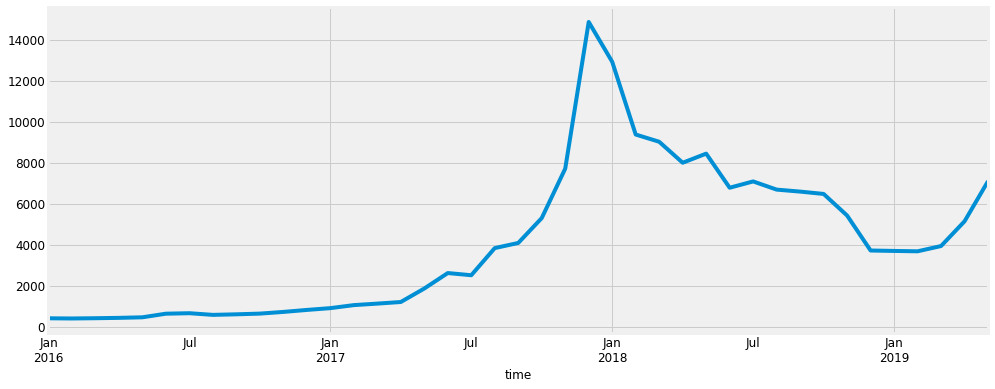

In [5]:
# Plotting the price over time i months.
month_hist.plot(figsize=(15,6))
plt.show()

---

# ARIMA prediction
ARIMA model is a statistical model for analyzing and forecasting time series data.

* Auto Regression tries to fit a line based on previous values. This is the 'p' in the ARIMA p-d-q formular. This value is setting how many months backwards we want to use to predict 1 month forward.

* Integrated making the data stationary. This is the 'd' in the ARIMA p-d-q formular. The data must be stationary in order to work with it in the SARIMA model. Stationary is, the mean variance should be constant.

* Moving Average is 



Skal vi skrive lidt tekst om hvad ARIMA er og hvad vi tager højde for i denne model?
Måske det om vi bruger seasonal?
Hvordan ser formlen ud?

desuden sagde hun der vigtigste var billede illustrationer. måske vi skal finde noget ift arima men også rnn lstm.
fx. til lstm kan vi tegne det som hun tegnede for os i dag når man forudsiger lstm

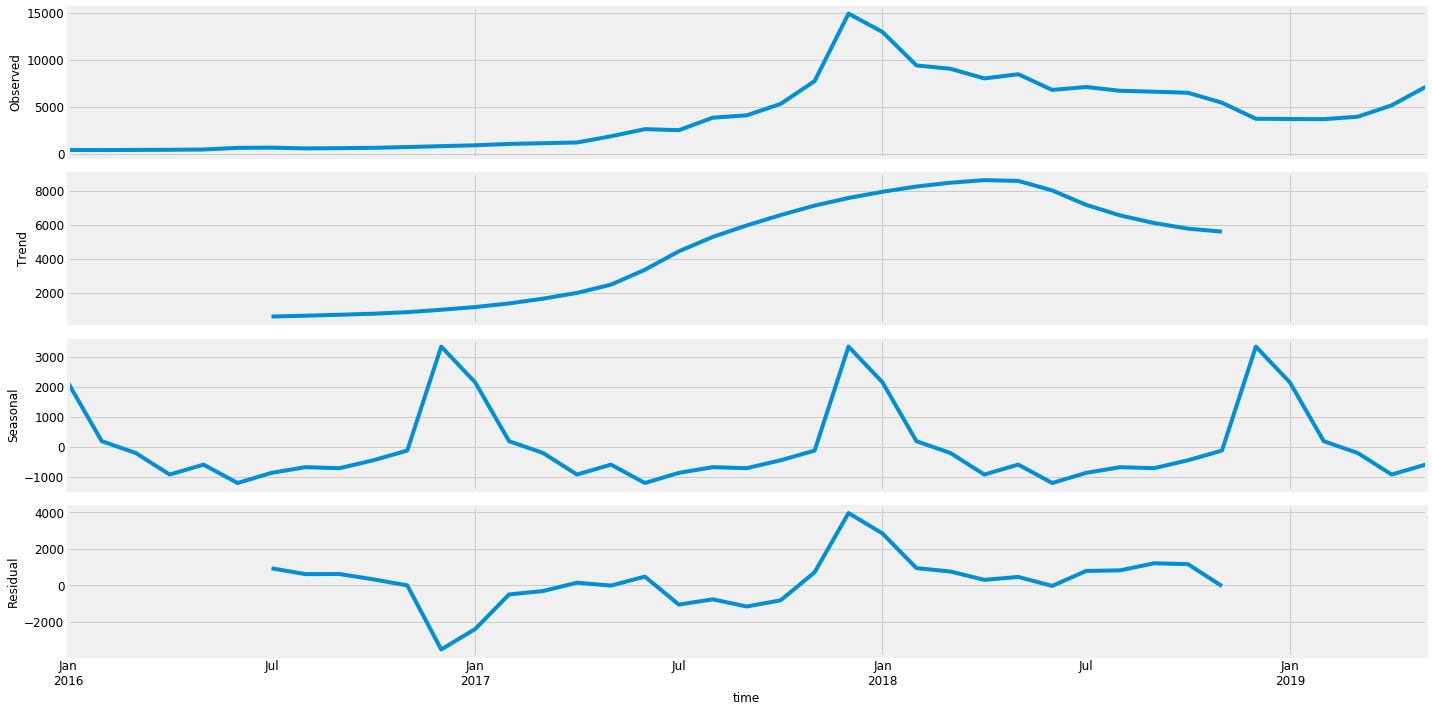

In [6]:
rcParams['figure.figsize'] = 20, 10

# Decomposing to visualize and identify trend, seasonality and residual.
# The graphs shows a opward going trend in the bitcoin market late 2016.
# There is a possible seasonality pattern at the end of the year with a big increase in price with a following decrease.
# Residual is noise. This is what there is left when removing trend and seasonal from the observed graph.
decomposition = sm.tsa.seasonal_decompose(month_hist, model='additive')
fig = decomposition.plot()
plt.show()

In [7]:
# ARIMA model (seasonal ARIMA, SARIMA)
# 'p' is the number of autoregressive terms (AR part). It allows to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.
# 'd' is the number of nonseasonal differences needed for stationarity. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.
# 'q' is the number of lagged forecast errors in the prediction equation (MA part). This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.
# These are the three integers (p, d, q) that are used to parametrize ARIMA models.
p = d = q = range(0, 3)

# pdq is an array of tuples. 
# Generating 2 arrays of tuples with examples of parameter combinations bewtween (0-1).
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


In [8]:
# We are trying to find the combination with the lowest AIC(an estimator to realative quaility of statistical models for a given set of data).
for param in pdq:
    for param_seasonal in seasonal_pdq:
        # Try since not all combinations makes sense, some will throw an error.
        try:
            # Using Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model(SARIMAX).
            # eXogenous argument is not given, which makes it a SARIMA model.
            model = sm.tsa.statespace.SARIMAX(month_hist,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = model.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        # If we come across an invalid combination, just skip it and continue.
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:805.1858405225734
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1345.0374581781577
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:568.6390406082792
ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:344.9426172065563
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:586.3326464230109


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:570.8158375244316
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:346.0098728273373
ARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:85.52861018500067
ARIMA(0, 0, 0)x(2, 0, 0, 12)12 - AIC:338.400356877102


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(2, 0, 1, 12)12 - AIC:340.6778135279364
ARIMA(0, 0, 0)x(2, 1, 0, 12)12 - AIC:79.57288414043101
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:743.0159962489446
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2531.424003729276
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:531.3516040103696
ARIMA(0, 0, 1)x(0, 2, 0, 12)12 - AIC:314.9040460227893
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:558.4154629967965
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:524.1647396170088
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:325.84254201192067
ARIMA(0, 0, 1)x(1, 2, 0, 12)12 - AIC:84.85870022454661
ARIMA(0, 0, 1)x(2, 0, 0, 12)12 - AIC:317.9581687721851
ARIMA(0, 0, 1)x(2, 0, 1, 12)12 - AIC:317.77232463234463


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(2, 1, 0, 12)12 - AIC:79.07931091225247
ARIMA(0, 0, 2)x(0, 0, 0, 12)12 - AIC:703.6815131037387
ARIMA(0, 0, 2)x(0, 0, 1, 12)12 - AIC:2487.2942334766494
ARIMA(0, 0, 2)x(0, 1, 0, 12)12 - AIC:507.70716870417243
ARIMA(0, 0, 2)x(0, 2, 0, 12)12 - AIC:294.85961291280887
ARIMA(0, 0, 2)x(1, 0, 0, 12)12 - AIC:545.7990420939474
ARIMA(0, 0, 2)x(1, 0, 1, 12)12 - AIC:494.49822751520907
ARIMA(0, 0, 2)x(1, 1, 0, 12)12 - AIC:316.8532554886252


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 2)x(1, 2, 0, 12)12 - AIC:86.79212874706619


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 2)x(2, 0, 0, 12)12 - AIC:309.86454843912566


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 2)x(2, 0, 1, 12)12 - AIC:309.8197456320676


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 2)x(2, 1, 0, 12)12 - AIC:90.51643346840996
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:684.905920363205
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1231.413509761773
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:506.31497596132317
ARIMA(0, 1, 0)x(0, 2, 0, 12)12 - AIC:301.0416845386589
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:502.4626869578364
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:487.19565182511855
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:274.74758629005754
ARIMA(0, 1, 0)x(1, 2, 0, 12)12 - AIC:65.89625686905158
ARIMA(0, 1, 0)x(2, 0, 0, 12)12 - AIC:276.55636339483976
ARIMA(0, 1, 0)x(2, 0, 1, 12)12 - AIC:277.65122742313207
ARIMA(0, 1, 0)x(2, 1, 0, 12)12 - AIC:67.8616319450819
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:668.2034839885878
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2196.07010596188
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:488.7622387525907
ARIMA(0, 1, 1)x(0, 2, 0, 12)12 - AIC:283.125246049581
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:502.98639876158586
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:470.7091189529092
ARIMA(0,

c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(2, 1, 0, 12)12 - AIC:66.39111409816798
ARIMA(0, 1, 2)x(0, 0, 0, 12)12 - AIC:653.4079054899976
ARIMA(0, 1, 2)x(0, 0, 1, 12)12 - AIC:2172.0208000520875
ARIMA(0, 1, 2)x(0, 1, 0, 12)12 - AIC:473.38822642116406
ARIMA(0, 1, 2)x(0, 2, 0, 12)12 - AIC:266.819828266054
ARIMA(0, 1, 2)x(1, 0, 0, 12)12 - AIC:504.8184332159402
ARIMA(0, 1, 2)x(1, 0, 1, 12)12 - AIC:455.85359307387733
ARIMA(0, 1, 2)x(1, 1, 0, 12)12 - AIC:276.1191940814882
ARIMA(0, 1, 2)x(1, 2, 0, 12)12 - AIC:68.3354131691867
ARIMA(0, 1, 2)x(2, 0, 0, 12)12 - AIC:276.29089613299755


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(2, 0, 1, 12)12 - AIC:271.3672044873817


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(2, 1, 0, 12)12 - AIC:67.43958316933482
ARIMA(0, 2, 0)x(0, 0, 0, 12)12 - AIC:685.0604933785559
ARIMA(0, 2, 0)x(0, 0, 1, 12)12 - AIC:935.0713530760746
ARIMA(0, 2, 0)x(0, 1, 0, 12)12 - AIC:499.60794050257334
ARIMA(0, 2, 0)x(0, 2, 0, 12)12 - AIC:288.11079210848044
ARIMA(0, 2, 0)x(1, 0, 0, 12)12 - AIC:497.88807398172037
ARIMA(0, 2, 0)x(1, 0, 1, 12)12 - AIC:1073.3377899116933
ARIMA(0, 2, 0)x(1, 1, 0, 12)12 - AIC:261.21870776805866

c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



ARIMA(0, 2, 0)x(1, 2, 0, 12)12 - AIC:52.83109974808947
ARIMA(0, 2, 0)x(2, 0, 0, 12)12 - AIC:262.9028520295797


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 2, 0)x(2, 0, 1, 12)12 - AIC:644.7193117119918
ARIMA(0, 2, 0)x(2, 1, 0, 12)12 - AIC:52.670700478914746
ARIMA(0, 2, 1)x(0, 0, 0, 12)12 - AIC:656.8060498122398
ARIMA(0, 2, 1)x(0, 0, 1, 12)12 - AIC:nan
ARIMA(0, 2, 1)x(0, 1, 0, 12)12 - AIC:474.4505925523319
ARIMA(0, 2, 1)x(0, 2, 0, 12)12 - AIC:266.32932667238106
ARIMA(0, 2, 1)x(1, 0, 0, 12)12 - AIC:488.95828435086264
ARIMA(0, 2, 1)x(1, 0, 1, 12)12 - AIC:2206.4444554214715
ARIMA(0, 2, 1)x(1, 1, 0, 12)12 - AIC:251.17340363786315
ARIMA(0, 2, 1)x(1, 2, 0, 12)12 - AIC:55.17514702186858
ARIMA(0, 2, 1)x(2, 0, 0, 12)12 - AIC:251.4730432054955


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 2, 1)x(2, 0, 1, 12)12 - AIC:663.6679511603759


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 2, 1)x(2, 1, 0, 12)12 - AIC:50.11839062383357
ARIMA(0, 2, 2)x(0, 0, 0, 12)12 - AIC:640.29509539609
ARIMA(0, 2, 2)x(0, 0, 1, 12)12 - AIC:nan
ARIMA(0, 2, 2)x(0, 1, 0, 12)12 - AIC:457.9086384097866
ARIMA(0, 2, 2)x(0, 2, 0, 12)12 - AIC:249.08719241825818
ARIMA(0, 2, 2)x(1, 0, 0, 12)12 - AIC:489.65117975571854
ARIMA(0, 2, 2)x(1, 0, 1, 12)12 - AIC:nan
ARIMA(0, 2, 2)x(1, 1, 0, 12)12 - AIC:253.15336059226007
ARIMA(0, 2, 2)x(1, 2, 0, 12)12 - AIC:67.06957222977128
ARIMA(0, 2, 2)x(2, 0, 0, 12)12 - AIC:253.41589646936077


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 2, 2)x(2, 0, 1, 12)12 - AIC:693.7452909808496


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 2, 2)x(2, 1, 0, 12)12 - AIC:59.185493009299066
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:703.2447627141762
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1199.3584787524353
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:524.5395952859353
ARIMA(1, 0, 0)x(0, 2, 0, 12)12 - AIC:321.32086954426927
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:506.06538923535595
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:506.3674000068788
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:271.59341369455433
ARIMA(1, 0, 0)x(1, 2, 0, 12)12 - AIC:67.2264927669521
ARIMA(1, 0, 0)x(2, 0, 0, 12)12 - AIC:268.91285537371857


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(2, 0, 1, 12)12 - AIC:270.0369543807115
ARIMA(1, 0, 0)x(2, 1, 0, 12)12 - AIC:78.42132739368886
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:686.2737971032122
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:2217.1772556246624
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:506.1920555502094
ARIMA(1, 0, 1)x(0, 2, 0, 12)12 - AIC:302.75028966405637
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:505.8774377115759

c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:489.6351293556817
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:263.6262634697571


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 2, 0, 12)12 - AIC:69.20882103537603
ARIMA(1, 0, 1)x(2, 0, 0, 12)12 - AIC:277.5468744078871
ARIMA(1, 0, 1)x(2, 0, 1, 12)12 - AIC:279.54578043292486


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(2, 1, 0, 12)12 - AIC:68.79847876967385
ARIMA(1, 0, 2)x(0, 0, 0, 12)12 - AIC:671.635735005739
ARIMA(1, 0, 2)x(0, 0, 1, 12)12 - AIC:86154.79568207008
ARIMA(1, 0, 2)x(0, 1, 0, 12)12 - AIC:491.0435838209885
ARIMA(1, 0, 2)x(0, 2, 0, 12)12 - AIC:286.66289455323596
ARIMA(1, 0, 2)x(1, 0, 0, 12)12 - AIC:506.9426246552131
ARIMA(1, 0, 2)x(1, 0, 1, 12)12 - AIC:474.7779297341947


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(1, 1, 0, 12)12 - AIC:267.8348073874259


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(1, 2, 0, 12)12 - AIC:72.55528493949147


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(2, 0, 0, 12)12 - AIC:266.5671172539491


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(2, 0, 1, 12)12 - AIC:282.1642217376839


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(2, 1, 0, 12)12 - AIC:82.87782376564223
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:685.181684876188


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1129.4398179427158
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:506.81152812910943
ARIMA(1, 1, 0)x(0, 2, 0, 12)12 - AIC:302.1756986085901
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:486.61300605981904
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:488.3614824417598
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:247.28339132949353
ARIMA(1, 1, 0)x(1, 2, 0, 12)12 - AIC:49.44731864218276
ARIMA(1, 1, 0)x(2, 0, 0, 12)12 - AIC:248.95648691353423
ARIMA(1, 1, 0)x(2, 0, 1, 12)12 - AIC:249.46679754640763


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(2, 1, 0, 12)12 - AIC:14.194903556921997
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:670.0623572969708
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:2294.215077718607
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:490.6662121422154
ARIMA(1, 1, 1)x(0, 2, 0, 12)12 - AIC:285.05218370187754
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:487.65527429920644
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:472.5856543885279
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:248.49586964183808


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 2, 0, 12)12 - AIC:57.79839380801101
ARIMA(1, 1, 1)x(2, 0, 0, 12)12 - AIC:248.3324846198929
ARIMA(1, 1, 1)x(2, 0, 1, 12)12 - AIC:251.0789801993286


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(2, 1, 0, 12)12 - AIC:46.15909616994228
ARIMA(1, 1, 2)x(0, 0, 0, 12)12 - AIC:655.5733382771981
ARIMA(1, 1, 2)x(0, 0, 1, 12)12 - AIC:2267.0669325271856
ARIMA(1, 1, 2)x(0, 1, 0, 12)12 - AIC:474.51423291093374
ARIMA(1, 1, 2)x(0, 2, 0, 12)12 - AIC:268.4469197425223
ARIMA(1, 1, 2)x(1, 0, 0, 12)12 - AIC:489.0145504085482
ARIMA(1, 1, 2)x(1, 0, 1, 12)12 - AIC:457.1163612748143


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(1, 1, 0, 12)12 - AIC:245.8491346187665


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(1, 2, 0, 12)12 - AIC:45.341611310077624
ARIMA(1, 1, 2)x(2, 0, 0, 12)12 - AIC:247.8837346251702


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(2, 0, 1, 12)12 - AIC:250.57033042729785


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(2, 1, 0, 12)12 - AIC:57.29442344972946
ARIMA(1, 2, 0)x(0, 0, 0, 12)12 - AIC:683.5320876431754


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 0)x(0, 0, 1, 12)12 - AIC:848.7661005838866
ARIMA(1, 2, 0)x(0, 1, 0, 12)12 - AIC:499.32878234227513
ARIMA(1, 2, 0)x(0, 2, 0, 12)12 - AIC:288.79163932705137
ARIMA(1, 2, 0)x(1, 0, 0, 12)12 - AIC:480.1982093389913


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 0)x(1, 0, 1, 12)12 - AIC:933.3350816721185
ARIMA(1, 2, 0)x(1, 1, 0, 12)12 - AIC:233.2421782746557
ARIMA(1, 2, 0)x(1, 2, 0, 12)12 - AIC:44.68449841552889
ARIMA(1, 2, 0)x(2, 0, 0, 12)12 - AIC:235.19522687418691


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 0)x(2, 0, 1, 12)12 - AIC:620.5027394965471
ARIMA(1, 2, 0)x(2, 1, 0, 12)12 - AIC:43.92973596246477
ARIMA(1, 2, 1)x(0, 0, 0, 12)12 - AIC:657.0742816194095
ARIMA(1, 2, 1)x(0, 0, 1, 12)12 - AIC:2176.3826458342023
ARIMA(1, 2, 1)x(0, 1, 0, 12)12 - AIC:475.75730529345725
ARIMA(1, 2, 1)x(0, 2, 0, 12)12 - AIC:267.55594241877304
ARIMA(1, 2, 1)x(1, 0, 0, 12)12 - AIC:473.2873441438267
ARIMA(1, 2, 1)x(1, 0, 1, 12)12 - AIC:2240.8248167117536
ARIMA(1, 2, 1)x(1, 1, 0, 12)12 - AIC:233.53292180937615
ARIMA(1, 2, 1)x(1, 2, 0, 12)12 - AIC:46.770414819312556


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 1)x(2, 0, 0, 12)12 - AIC:235.17620834396217


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 1)x(2, 0, 1, 12)12 - AIC:599.6142760504976


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 1)x(2, 1, 0, 12)12 - AIC:43.63562065619972
ARIMA(1, 2, 2)x(0, 0, 0, 12)12 - AIC:640.3696431469255
ARIMA(1, 2, 2)x(0, 0, 1, 12)12 - AIC:2023.4133140751774
ARIMA(1, 2, 2)x(0, 1, 0, 12)12 - AIC:459.811256993347
ARIMA(1, 2, 2)x(0, 2, 0, 12)12 - AIC:250.9979783668349
ARIMA(1, 2, 2)x(1, 0, 0, 12)12 - AIC:473.883645480108
ARIMA(1, 2, 2)x(1, 0, 1, 12)12 - AIC:2030.149409656471
ARIMA(1, 2, 2)x(1, 1, 0, 12)12 - AIC:234.18939671045683


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(1, 2, 0, 12)12 - AIC:45.88885518600318


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(2, 0, 0, 12)12 - AIC:239.096748573035


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(2, 0, 1, 12)12 - AIC:621.6382481992835


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(2, 1, 0, 12)12 - AIC:47.647595935612486
ARIMA(2, 0, 0)x(0, 0, 0, 12)12 - AIC:686.7598078144888


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 0)x(0, 0, 1, 12)12 - AIC:1170.1422733375318
ARIMA(2, 0, 0)x(0, 1, 0, 12)12 - AIC:506.36797843646707
ARIMA(2, 0, 0)x(0, 2, 0, 12)12 - AIC:302.7991917906596
ARIMA(2, 0, 0)x(1, 0, 0, 12)12 - AIC:490.29001795801514
ARIMA(2, 0, 0)x(1, 0, 1, 12)12 - AIC:490.243006856188
ARIMA(2, 0, 0)x(1, 1, 0, 12)12 - AIC:247.9585021804197
ARIMA(2, 0, 0)x(1, 2, 0, 12)12 - AIC:64.35932505588671
ARIMA(2, 0, 0)x(2, 0, 0, 12)12 - AIC:246.39774392451352


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 0)x(2, 0, 1, 12)12 - AIC:254.2934957888067


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 0)x(2, 1, 0, 12)12 - AIC:62.57033621926759
ARIMA(2, 0, 1)x(0, 0, 0, 12)12 - AIC:688.2046278284706
ARIMA(2, 0, 1)x(0, 0, 1, 12)12 - AIC:2218.964836501198
ARIMA(2, 0, 1)x(0, 1, 0, 12)12 - AIC:508.1845539878227
ARIMA(2, 0, 1)x(0, 2, 0, 12)12 - AIC:304.7474739523438
ARIMA(2, 0, 1)x(1, 0, 0, 12)12 - AIC:491.34088004243944
ARIMA(2, 0, 1)x(1, 0, 1, 12)12 - AIC:491.49030662180024


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(1, 1, 0, 12)12 - AIC:267.75741154662063


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(1, 2, 0, 12)12 - AIC:63.93280624129154


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(2, 0, 0, 12)12 - AIC:250.07033007965686


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(2, 0, 1, 12)12 - AIC:263.48789823992786


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(2, 1, 0, 12)12 - AIC:64.76477576400326
ARIMA(2, 0, 2)x(0, 0, 0, 12)12 - AIC:673.899396563154
ARIMA(2, 0, 2)x(0, 0, 1, 12)12 - AIC:2215.9514294982923
ARIMA(2, 0, 2)x(0, 1, 0, 12)12 - AIC:492.40814271013176
ARIMA(2, 0, 2)x(0, 2, 0, 12)12 - AIC:287.0005096099376
ARIMA(2, 0, 2)x(1, 0, 0, 12)12 - AIC:490.83969425329957
ARIMA(2, 0, 2)x(1, 0, 1, 12)12 - AIC:476.77956901384505


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(1, 1, 0, 12)12 - AIC:250.36067216854713


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(1, 2, 0, 12)12 - AIC:69.5676462649885


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 0, 0, 12)12 - AIC:265.3062237501589


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 0, 1, 12)12 - AIC:267.2712660513779


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 1, 0, 12)12 - AIC:67.22217129022923
ARIMA(2, 1, 0)x(0, 0, 0, 12)12 - AIC:669.6568002971889
ARIMA(2, 1, 0)x(0, 0, 1, 12)12 - AIC:1342.8493829862
ARIMA(2, 1, 0)x(0, 1, 0, 12)12 - AIC:490.47613382120596

c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



ARIMA(2, 1, 0)x(0, 2, 0, 12)12 - AIC:284.8878340893482
ARIMA(2, 1, 0)x(1, 0, 0, 12)12 - AIC:470.93333805983815
ARIMA(2, 1, 0)x(1, 0, 1, 12)12 - AIC:472.53827581854796
ARIMA(2, 1, 0)x(1, 1, 0, 12)12 - AIC:231.36546478066424
ARIMA(2, 1, 0)x(1, 2, 0, 12)12 - AIC:45.841093549987335
ARIMA(2, 1, 0)x(2, 0, 0, 12)12 - AIC:232.8796157767846


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(2, 0, 1, 12)12 - AIC:234.96699692946987
ARIMA(2, 1, 0)x(2, 1, 0, 12)12 - AIC:34.1153481663969
ARIMA(2, 1, 1)x(0, 0, 0, 12)12 - AIC:671.7042354201744
ARIMA(2, 1, 1)x(0, 0, 1, 12)12 - AIC:nan
ARIMA(2, 1, 1)x(0, 1, 0, 12)12 - AIC:492.51775992196366
ARIMA(2, 1, 1)x(0, 2, 0, 12)12 - AIC:286.9878304641395
ARIMA(2, 1, 1)x(1, 0, 0, 12)12 - AIC:472.8944544118985
ARIMA(2, 1, 1)x(1, 0, 1, 12)12 - AIC:474.42907300143094
ARIMA(2, 1, 1)x(1, 1, 0, 12)12 - AIC:232.13190803889995
ARIMA(2, 1, 1)x(1, 2, 0, 12)12 - AIC:48.12794497031113
ARIMA(2, 1, 1)x(2, 0, 0, 12)12 - AIC:231.0479678217699


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(2, 0, 1, 12)12 - AIC:232.96774426378084
ARIMA(2, 1, 1)x(2, 1, 0, 12)12 - AIC:46.49822422715665
ARIMA(2, 1, 2)x(0, 0, 0, 12)12 - AIC:657.3862095312663
ARIMA(2, 1, 2)x(0, 0, 1, 12)12 - AIC:3669.2137580906115
ARIMA(2, 1, 2)x(0, 1, 0, 12)12 - AIC:475.4835576926023
ARIMA(2, 1, 2)x(0, 2, 0, 12)12 - AIC:270.44863191393273
ARIMA(2, 1, 2)x(1, 0, 0, 12)12 - AIC:474.02358418513825
ARIMA(2, 1, 2)x(1, 0, 1, 12)12 - AIC:459.5946779673215


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(1, 1, 0, 12)12 - AIC:246.76967909960027
ARIMA(2, 1, 2)x(1, 2, 0, 12)12 - AIC:50.79217995108665


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(2, 0, 0, 12)12 - AIC:228.89034468728283


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(2, 0, 1, 12)12 - AIC:236.52949901726336


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(2, 1, 0, 12)12 - AIC:49.74854169120782
ARIMA(2, 2, 0)x(0, 0, 0, 12)12 - AIC:663.9753886071394


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 0)x(0, 0, 1, 12)12 - AIC:979.1977270998894
ARIMA(2, 2, 0)x(0, 1, 0, 12)12 - AIC:479.48537835376754
ARIMA(2, 2, 0)x(0, 2, 0, 12)12 - AIC:269.3882042246844
ARIMA(2, 2, 0)x(1, 0, 0, 12)12 - AIC:461.8580487663753
ARIMA(2, 2, 0)x(1, 0, 1, 12)12 - AIC:996.1922128115388
ARIMA(2, 2, 0)x(1, 1, 0, 12)12 - AIC:217.42733248174042
ARIMA(2, 2, 0)x(1, 2, 0, 12)12 - AIC:27.26063096414864
ARIMA(2, 2, 0)x(2, 0, 0, 12)12 - AIC:218.86053312362984


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 0)x(2, 0, 1, 12)12 - AIC:533.0700865579147
ARIMA(2, 2, 0)x(2, 1, 0, 12)12 - AIC:27.93941514000488
ARIMA(2, 2, 1)x(0, 0, 0, 12)12 - AIC:656.9846061835848
ARIMA(2, 2, 1)x(0, 0, 1, 12)12 - AIC:2976.7024938850277
ARIMA(2, 2, 1)x(0, 1, 0, 12)12 - AIC:476.371785504494
ARIMA(2, 2, 1)x(0, 2, 0, 12)12 - AIC:269.1438417588947
ARIMA(2, 2, 1)x(1, 0, 0, 12)12 - AIC:457.4219225859451
ARIMA(2, 2, 1)x(1, 0, 1, 12)12 - AIC:1961.7444739895218


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 1)x(1, 1, 0, 12)12 - AIC:219.30845822623903
ARIMA(2, 2, 1)x(1, 2, 0, 12)12 - AIC:29.359066255415634


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 1)x(2, 0, 0, 12)12 - AIC:221.37103308158123
ARIMA(2, 2, 1)x(2, 0, 1, 12)12 - AIC:580.5300379585607
ARIMA(2, 2, 1)x(2, 1, 0, 12)12 - AIC:29.956954426624385


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 2)x(0, 0, 0, 12)12 - AIC:641.8923568989668
ARIMA(2, 2, 2)x(0, 0, 1, 12)12 - AIC:nan
ARIMA(2, 2, 2)x(0, 1, 0, 12)12 - AIC:461.7328228133032
ARIMA(2, 2, 2)x(0, 2, 0, 12)12 - AIC:252.94743546244007
ARIMA(2, 2, 2)x(1, 0, 0, 12)12 - AIC:458.6923495315261


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 2)x(1, 0, 1, 12)12 - AIC:1886.59534780553


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 2)x(1, 1, 0, 12)12 - AIC:230.16112680148436
ARIMA(2, 2, 2)x(1, 2, 0, 12)12 - AIC:31.666857899676334


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 2)x(2, 0, 0, 12)12 - AIC:233.38755535041852
ARIMA(2, 2, 2)x(2, 0, 1, 12)12 - AIC:616.5503832855914
ARIMA(2, 2, 2)x(2, 1, 0, 12)12 - AIC:32.08410311967158


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [9]:
#ARIMA(4, 4, 4)x(4, 1, 1, 12)12 - AIC:96.11295809398507
#ARIMA(1, 1, 0)x(2, 1, 0, 12)12 - AIC:17.271069152913338

model = sm.tsa.statespace.SARIMAX(month_hist,
                                order=(1, 1, 0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = model.fit()

print(results.summary().tables[0])

                                 Statespace Model Results                                 
Dep. Variable:                     Weighted_Price   No. Observations:                   41
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -120.642
Date:                            Tue, 28 May 2019   AIC                            247.283
Time:                                    16:25:20   BIC                            249.408
Sample:                                01-01-2016   HQIC                           247.261
                                     - 05-01-2019                                         
Covariance Type:                              opg                                         


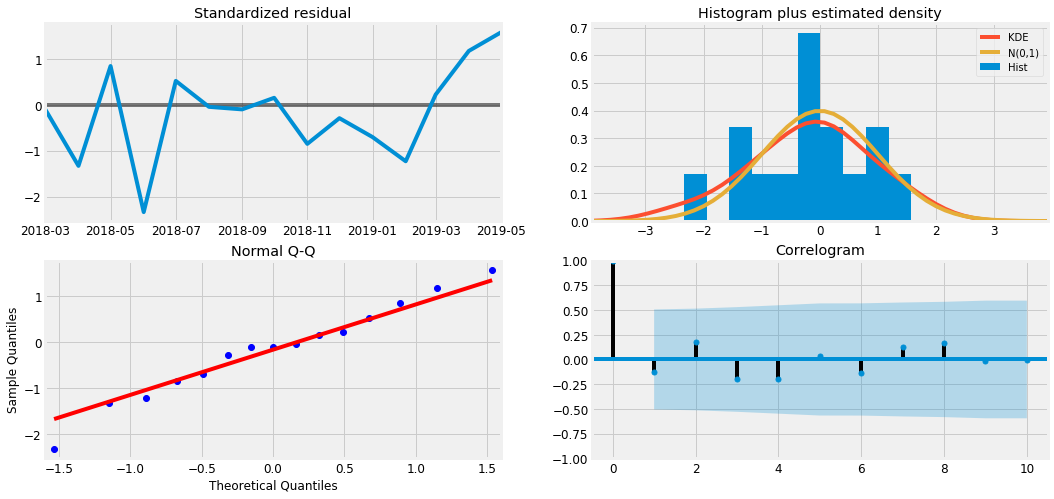

In [10]:
# Plitting model diagnostics to investigate unusual behavior.
# Residual is the difference between true and predicted value.

# Normal Quantile-Quantile is a way to visualize if the data were normally distributes. The closer to the line, the more normally distributed.
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## Testing the model

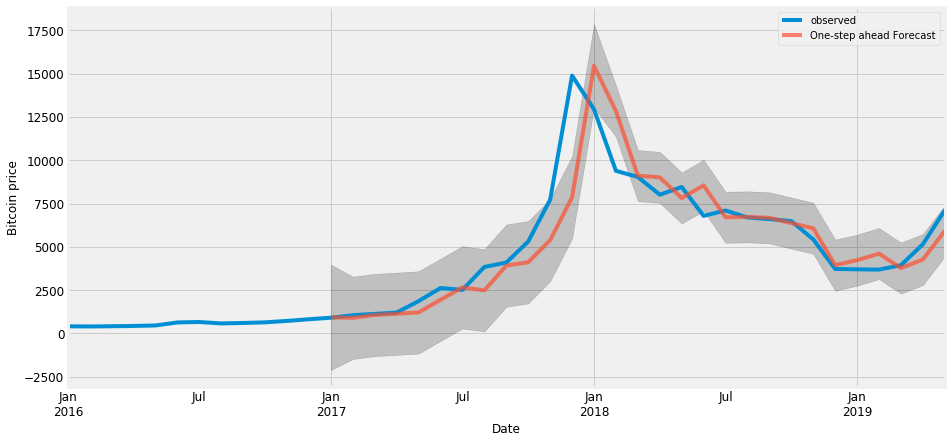

In [11]:
# Making a prediction from 1. Janurary 2017 to now, so we can compare the result with the actual observed graph.
pred = results.get_prediction(start=('2017-01-01'), dynamic=False)


# Plotting the observed graph and the 'one-step forecasting',
ax = month_hist.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

# Plotting the confidence interval on the forecast.
# This is the interval of the forecasts higest and lowest predicted price.
# The plotted line is the mean in the confidence interval.
pred_ci = pred.conf_int()
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Bitcoin price')
plt.legend()
plt.show()

In [12]:
# This is the confidence interval.
# It shows the difference between lower and upper values of predicted weighted price over time.
print(pred_ci)

            lower Weighted_Price  upper Weighted_Price
time                                                  
2017-01-01          -2112.237226           3976.878861
2017-02-01          -1479.235080           3277.057749
2017-03-01          -1311.032928           3442.740791
2017-04-01          -1240.811504           3512.960103
2017-05-01          -1162.941760           3590.829840
2017-06-01           -434.125198           4319.646402
2017-07-01            284.864724           5038.636324
2017-08-01            111.218280           4864.989879
2017-09-01           1539.414781           6293.186381
2017-10-01           1734.759146           6488.530745
2017-11-01           3010.731917           7764.503386
2017-12-01           5489.883693          10243.515389
2018-01-01          13045.645304          17867.539941
2018-02-01          11366.531450          14323.305707
2018-03-01           7639.071650          10590.117188
2018-04-01           7538.928571          10489.974108
2018-05-01

In [13]:
# @£@£@£@£@£@Forventes ike at skulle bruges
#mse = mean_squared_error(y_truth, y_forecasted)
#print(f'Mean squared error:',mse)

In [14]:
# Calculating the mean absolute error.
y_forecasted = pred.predicted_mean
y_truth = month_hist['2017-01-01':]

# Sklearn method takes the actual value and the predicted value as parameters.
# The mean absolute error is an indication for @£@£@£@£ TOBIAS LÆSER OP.
mae = mean_absolute_error(y_truth, y_forecasted)
print('Mean absolute error',mae)

Mean absolute error 982.5537281080826


In [15]:
#@£@£@£@£@£@£ Forventes ikek at skulle bruges
#rmse = sqrt(mse)
#print(f'Root mean squared error:',rmse)

## Future prediction

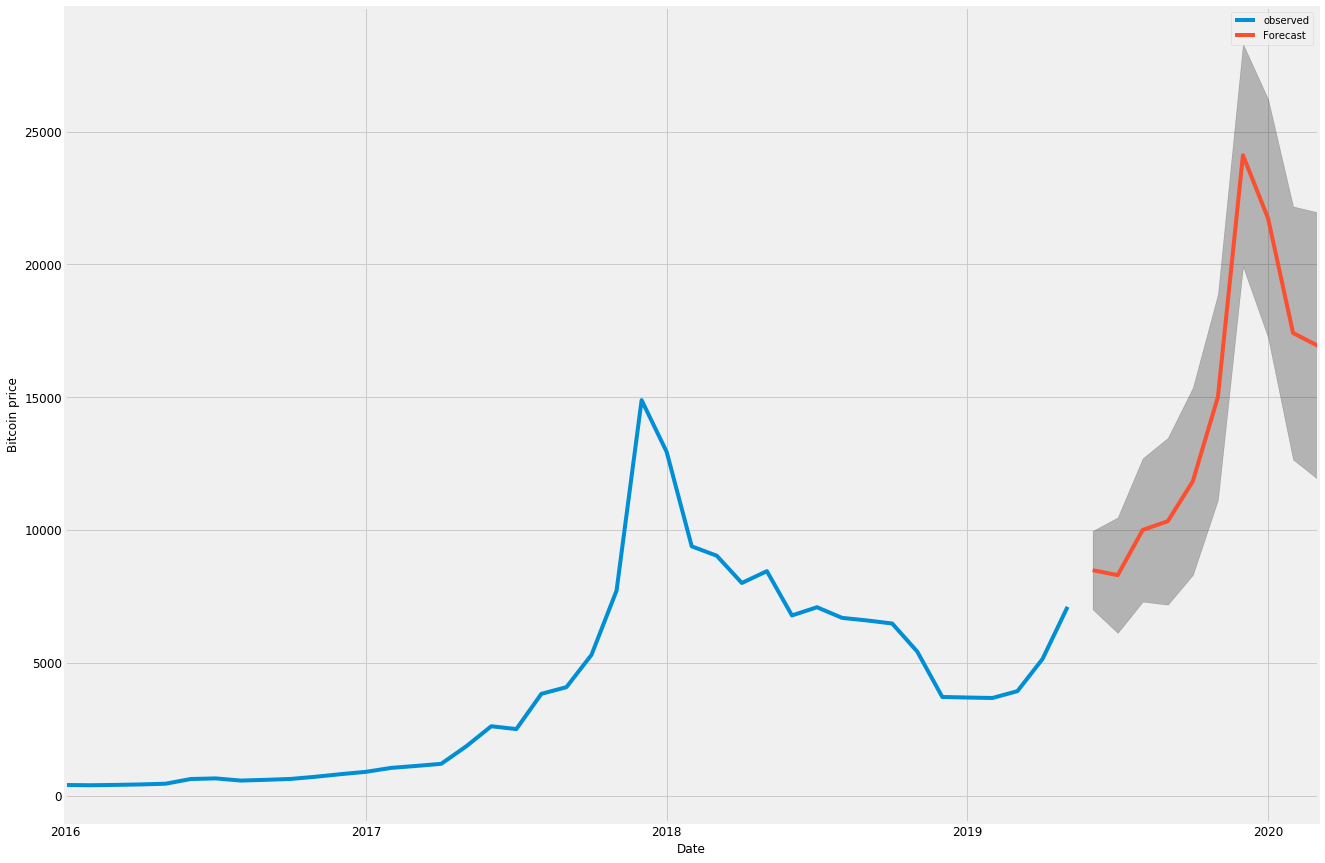

In [16]:
# We generate a forecast for the furture graph of Bitcoin.
# We call the method get_forecast which takes a parameter 'steps', as how many steps into the future do we want to forecast.
future_pred = results.get_forecast(steps=10)

# We plot the observed graph of Bitcoin prices.
ax = month_hist.plot(label='observed', figsize=(20, 15))
future_pred.predicted_mean.plot(ax=ax, label='Forecast')

# Plotting the confidence interval on the forecast.
# This is the interval of the forecasts higest and lowest predicted price.
# The plotted line is the mean in the confidence interval.
pred_ci = future_pred.conf_int()
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Bitcoin price')
plt.legend()
plt.show()

## Conclusion
The model does seem to capture the trends and seasonality in the Bitcoin price. However 



---

# RNN LSTM Prediction
A **reccurent network** is networks with loops in them.
A loop allows information to be passed from on node in a network to another.
The image below illustrates a recurrent network. The loop to left is equal to the illustration of a loop on the right.
The network takes an input but also the output from the previous nodes as input to the current step.

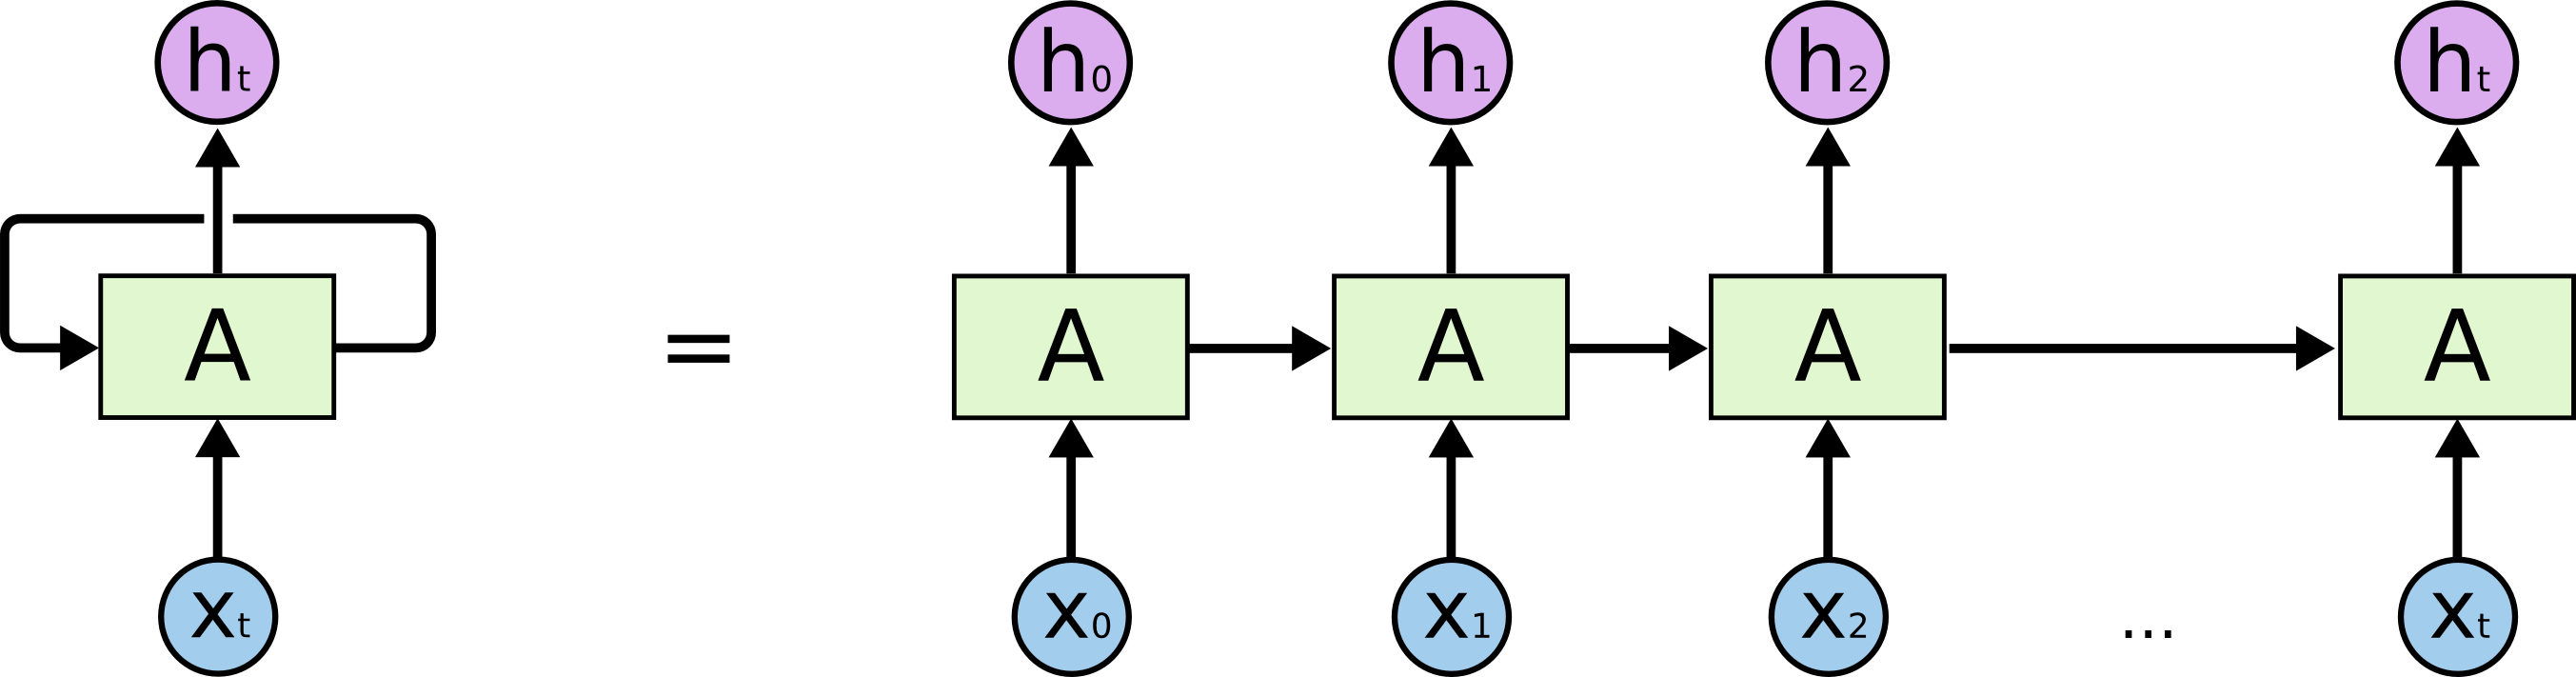


The idea behind the recurrent network is that it creates a kind of memory, which remembers all information about what has been calculated.

The **long-short term memory** comes into place as a hidden layer in the network. It's purpose is to enable RNN to remember inputs over a long period of time. The LSTM network has 3 gates. 
* Input gate, decides what is relevant to add from the current step.
* Forget gate, decides what is relevant to keep from prior steps and deletes information if it isn't important.
* Output gate, determines what the next hidden state should be.

With the above gates the model output the information to the next node & layer using Sigmoid and tanh layers.

In [17]:
# Reshaping numpy.ndarray from 1D array to 2D array
values = hist['Weighted_Price'].values.reshape(-1,1)
print(values[0])
# Converting the values to float.
values = values.astype('float32')
# Transform values to values between 0 and 1.
# This is the type of input LSTM takes.
scaler = MinMaxScaler(feature_range=(0, 1))
# Fit to data, then transform it.
scaled = scaler.fit_transform(values)

# Get the length of the new item scaled
print("Length of the new datframe : " + str(len(scaled)))

# Get the first 5 elements from the scaled dataframe
print(scaled[0:5,])

[1113.4375]
Length of the new datframe : 2001
[[0.05196624]
 [0.04434619]
 [0.03316076]
 [0.03275506]
 [0.03938658]]


In [18]:
# Divide scaled data into 80% train and 40% test with overlapping.
train_size = int(len(scaled) * 0.8)
print("Train Size : " + str(train_size))

test_size = int(len(scaled) * 0.6)
print("Test Size : " + str(len(scaled) - test_size))

train, test = scaled[:train_size,:], scaled[test_size:len(scaled),:]
print("Length of training data : " + str(len(train)))
print("Length of testing data : " + str(len(test)))

Train Size : 1600
Test Size : 801
Length of training data : 1600
Length of testing data : 801


In [19]:
# Function for creating dataset with look back (y refers to previous x)
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        # fx: 
        # 1st iteration - X:  [0.04680875] , Y:  0.051758032
        # 2nd iteration - X:  [0.05175803] , Y:  0.05387902
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [20]:
# Calling the create_dataset function with loop_back=1.
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(1599, 1)
(1599,)
(800, 1)
(800,)


In [21]:
# Transform from 2D array to 3D array
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print(trainX.shape)
print(testX.shape)

(1599, 1, 1)
(800, 1, 1)


In [187]:
# Initialise the sequential model
model = Sequential()

# Add the LSTM hidden layer with 100 nodes
model.add(CuDNNLSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))

# Adding a
model.add(Dropout(0.2))

# Add the output layer
model.add(Dense(1))

# Compile the model with Mean Absolute Error as the loss factor and ADAM as the optimiser
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])

# Fit the model using the training and testing data
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=1, shuffle=False)

Train on 1599 samples, validate on 800 samples
Epoch 1/300
1599/1599 [==============================] - 2s 1ms/step - loss: 0.0864 - acc: 6.2539e-04 - val_loss: 0.2805 - val_acc: 0.0000e+00
Epoch 2/300
1599/1599 [==============================] - 0s 47us/step - loss: 0.0806 - acc: 6.2539e-04 - val_loss: 0.2662 - val_acc: 0.0000e+00
Epoch 3/300
1599/1599 [==============================] - 0s 47us/step - loss: 0.0782 - acc: 6.2539e-04 - val_loss: 0.2573 - val_acc: 0.0000e+00
Epoch 4/300
1599/1599 [==============================] - 0s 51us/step - loss: 0.0751 - acc: 6.2539e-04 - val_loss: 0.2477 - val_acc: 0.0000e+00
Epoch 5/300
1599/1599 [==============================] - 0s 53us/step - loss: 0.0722 - acc: 6.2539e-04 - val_loss: 0.2373 - val_acc: 0.0000e+00
Epoch 6/300
1599/1599 [==============================] - 0s 49us/step - loss: 0.0692 - acc: 6.2539e-04 - val_loss: 0.2260 - val_acc: 0.0000e+00
Epoch 7/300
1599/1599 [==============================] - 0s 51us/step - loss: 0.0661 - acc

Epoch 60/300
1599/1599 [==============================] - 0s 51us/step - loss: 0.0052 - acc: 0.0013 - val_loss: 0.0086 - val_acc: 0.0012
Epoch 61/300
1599/1599 [==============================] - 0s 48us/step - loss: 0.0062 - acc: 0.0013 - val_loss: 0.0087 - val_acc: 0.0012
Epoch 62/300
1599/1599 [==============================] - 0s 47us/step - loss: 0.0080 - acc: 0.0013 - val_loss: 0.0097 - val_acc: 0.0012
Epoch 63/300
1599/1599 [==============================] - 0s 44us/step - loss: 0.0083 - acc: 0.0013 - val_loss: 0.0098 - val_acc: 0.0012
Epoch 64/300
1599/1599 [==============================] - 0s 46us/step - loss: 0.0098 - acc: 0.0013 - val_loss: 0.0126 - val_acc: 0.0012
Epoch 65/300
1599/1599 [==============================] - 0s 48us/step - loss: 0.0108 - acc: 0.0013 - val_loss: 0.0105 - val_acc: 0.0012
Epoch 66/300
1599/1599 [==============================] - 0s 46us/step - loss: 0.0116 - acc: 0.0013 - val_loss: 0.0104 - val_acc: 0.0012
Epoch 67/300
1599/1599 [=================

1599/1599 [==============================] - 0s 47us/step - loss: 0.0083 - acc: 0.0013 - val_loss: 0.0105 - val_acc: 0.0012
Epoch 120/300
1599/1599 [==============================] - 0s 46us/step - loss: 0.0094 - acc: 0.0013 - val_loss: 0.0100 - val_acc: 0.0012
Epoch 121/300
1599/1599 [==============================] - 0s 46us/step - loss: 0.0137 - acc: 0.0013 - val_loss: 0.0101 - val_acc: 0.0012
Epoch 122/300
1599/1599 [==============================] - 0s 47us/step - loss: 0.0081 - acc: 0.0013 - val_loss: 0.0142 - val_acc: 0.0012
Epoch 123/300
1599/1599 [==============================] - 0s 48us/step - loss: 0.0066 - acc: 0.0013 - val_loss: 0.0088 - val_acc: 0.0012
Epoch 124/300
1599/1599 [==============================] - 0s 42us/step - loss: 0.0081 - acc: 0.0013 - val_loss: 0.0106 - val_acc: 0.0012
Epoch 125/300
1599/1599 [==============================] - 0s 47us/step - loss: 0.0095 - acc: 0.0013 - val_loss: 0.0104 - val_acc: 0.0012
Epoch 126/300
1599/1599 [=======================

1599/1599 [==============================] - 0s 47us/step - loss: 0.0052 - acc: 0.0013 - val_loss: 0.0096 - val_acc: 0.0012
Epoch 179/300
1599/1599 [==============================] - 0s 46us/step - loss: 0.0076 - acc: 0.0013 - val_loss: 0.0091 - val_acc: 0.0012
Epoch 180/300
1599/1599 [==============================] - 0s 43us/step - loss: 0.0073 - acc: 0.0013 - val_loss: 0.0108 - val_acc: 0.0012
Epoch 181/300
1599/1599 [==============================] - 0s 47us/step - loss: 0.0078 - acc: 0.0013 - val_loss: 0.0106 - val_acc: 0.0012
Epoch 182/300
1599/1599 [==============================] - 0s 47us/step - loss: 0.0056 - acc: 0.0013 - val_loss: 0.0091 - val_acc: 0.0012
Epoch 183/300
1599/1599 [==============================] - 0s 48us/step - loss: 0.0090 - acc: 0.0013 - val_loss: 0.0119 - val_acc: 0.0012
Epoch 184/300
1599/1599 [==============================] - 0s 47us/step - loss: 0.0074 - acc: 0.0013 - val_loss: 0.0100 - val_acc: 0.0012
Epoch 185/300
1599/1599 [=======================

1599/1599 [==============================] - 0s 58us/step - loss: 0.0100 - acc: 0.0013 - val_loss: 0.0093 - val_acc: 0.0012
Epoch 238/300
1599/1599 [==============================] - 0s 55us/step - loss: 0.0058 - acc: 0.0013 - val_loss: 0.0085 - val_acc: 0.0012
Epoch 239/300
1599/1599 [==============================] - 0s 47us/step - loss: 0.0050 - acc: 0.0013 - val_loss: 0.0084 - val_acc: 0.0012
Epoch 240/300
1599/1599 [==============================] - 0s 49us/step - loss: 0.0057 - acc: 0.0013 - val_loss: 0.0088 - val_acc: 0.0012
Epoch 241/300
1599/1599 [==============================] - 0s 51us/step - loss: 0.0050 - acc: 0.0013 - val_loss: 0.0086 - val_acc: 0.0012
Epoch 242/300
1599/1599 [==============================] - 0s 49us/step - loss: 0.0052 - acc: 0.0013 - val_loss: 0.0084 - val_acc: 0.0012
Epoch 243/300
1599/1599 [==============================] - 0s 49us/step - loss: 0.0060 - acc: 0.0013 - val_loss: 0.0087 - val_acc: 0.0012
Epoch 244/300
1599/1599 [=======================

1599/1599 [==============================] - 0s 50us/step - loss: 0.0089 - acc: 0.0013 - val_loss: 0.0095 - val_acc: 0.0012
Epoch 297/300
1599/1599 [==============================] - 0s 50us/step - loss: 0.0092 - acc: 0.0013 - val_loss: 0.0094 - val_acc: 0.0012
Epoch 298/300
1599/1599 [==============================] - 0s 47us/step - loss: 0.0062 - acc: 0.0013 - val_loss: 0.0084 - val_acc: 0.0012
Epoch 299/300
1599/1599 [==============================] - 0s 47us/step - loss: 0.0054 - acc: 0.0013 - val_loss: 0.0088 - val_acc: 0.0012
Epoch 300/300
1599/1599 [==============================] - 0s 49us/step - loss: 0.0079 - acc: 0.0013 - val_loss: 0.0102 - val_acc: 0.0012


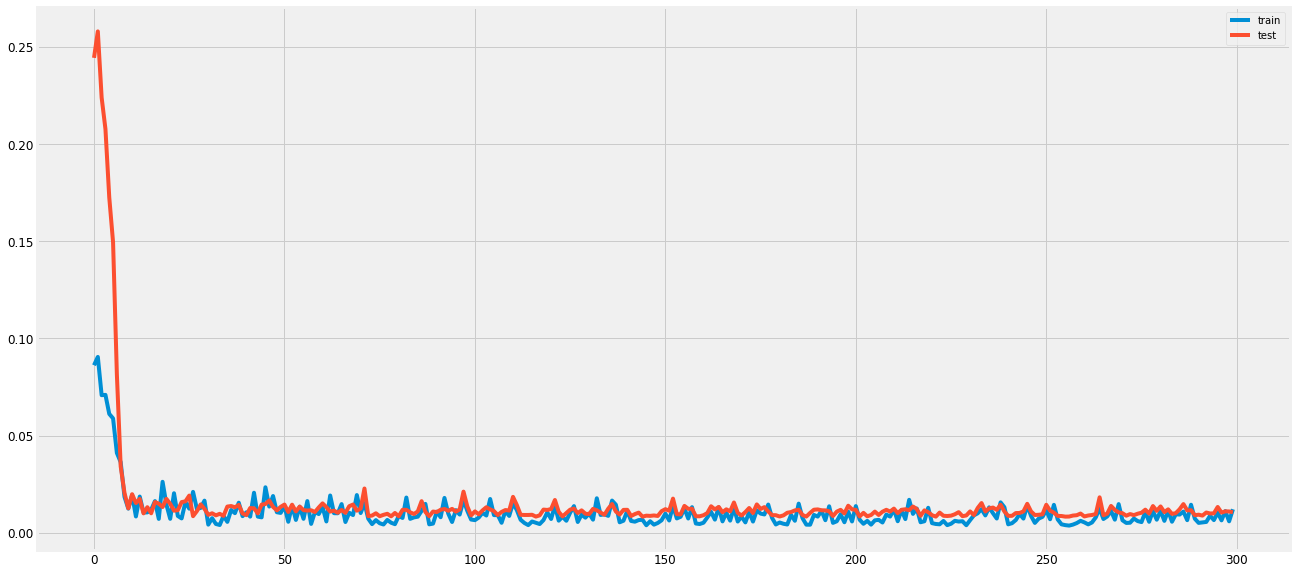

In [177]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

(800, 1)
[0.04929956]


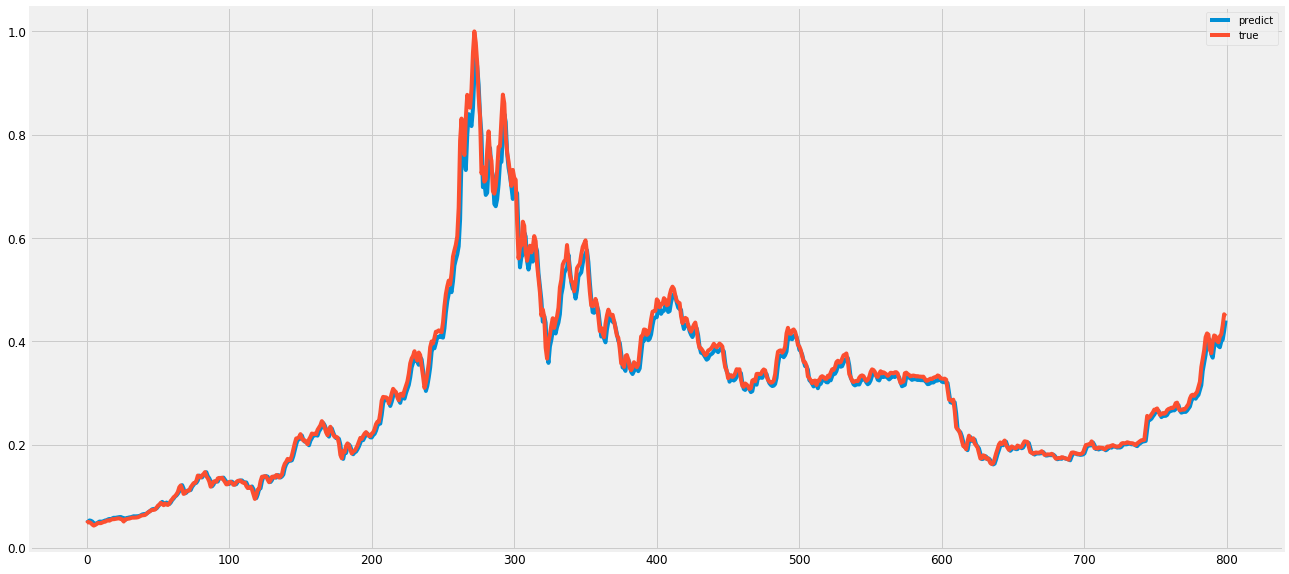

In [178]:
yhat = model.predict(testX) # Here yhat is the predicted value from the test set (y_pred)
print(yhat.shape)
print(yhat[0])

plt.plot(yhat, label='predict')
plt.plot(testY, label='true')
plt.legend()
plt.show()

In [179]:
# scaler = MinMaxScaler(feature_range=(0, 1)) as used before for fit_transform and MinMaxScaler
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

print(yhat_inverse.shape)
print(testY_inverse.shape)

print(yhat_inverse[0])
print(testY_inverse[0])

(800, 1)
(800, 1)
[1062.3982]
[1033.165]


In [180]:
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 342.027


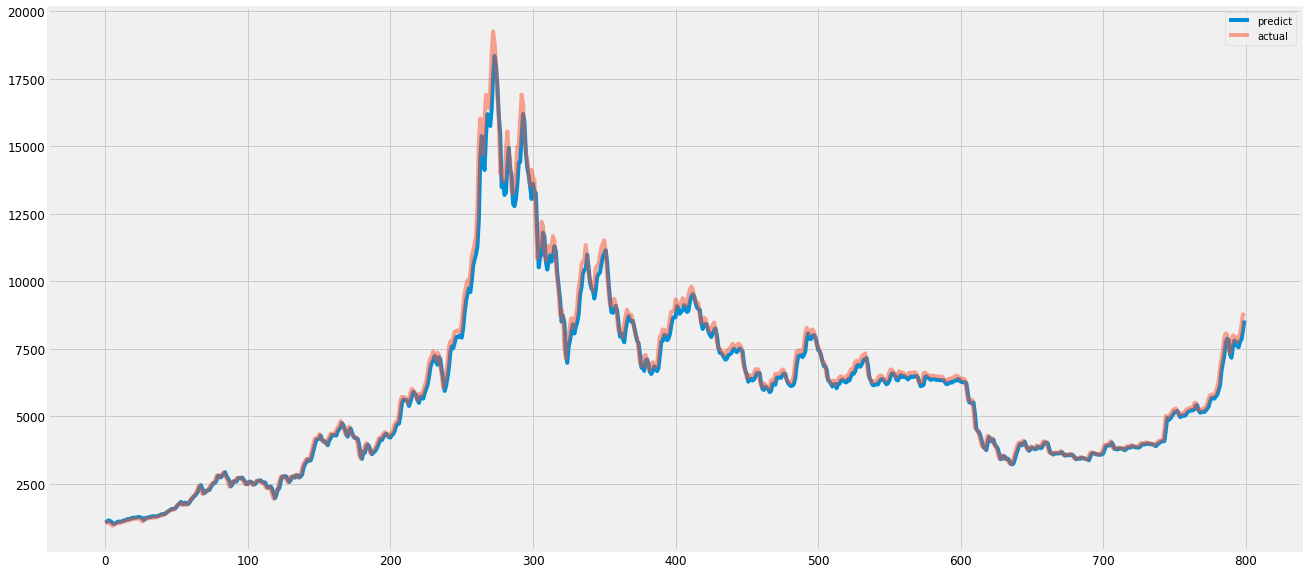

In [181]:
plt.plot(yhat_inverse, label='predict')
plt.plot(testY_inverse, label='actual', alpha=0.5)
plt.legend()
plt.show()

In [182]:
Xtest = testX

In [185]:
x = np.zeros((1,1,1))
x[[0]] = yhat[len(yhat)-1][0]
preds = []
#model.reset_states()
for i in range(1200):
    yklat = model.predict(Xtest) # Here yhat is the predicted value from the test set (y_pred)
    #print(yklat)
    preds.append(yklat[0][0])
    #print('X: ', x, ', Y: ', yklat)
    #print(yklat[len(yklat)-1][0])
    y = np.zeros((1,1,1))
    y[[0]] = yklat[len(yklat)-1][0]
    
    Xtest = np.append(Xtest, y, axis=0)
    #x[[0]] = yklat[0][0]
    
    #model.reset_states()
    
print(yklat.shape)
print(yklat[0])
print(yklat)

(2119, 1)
[0.04929956]
[[0.04929956]
 [0.05066364]
 [0.05326683]
 ...
 [0.13989124]
 [0.13989124]
 [0.13989124]]


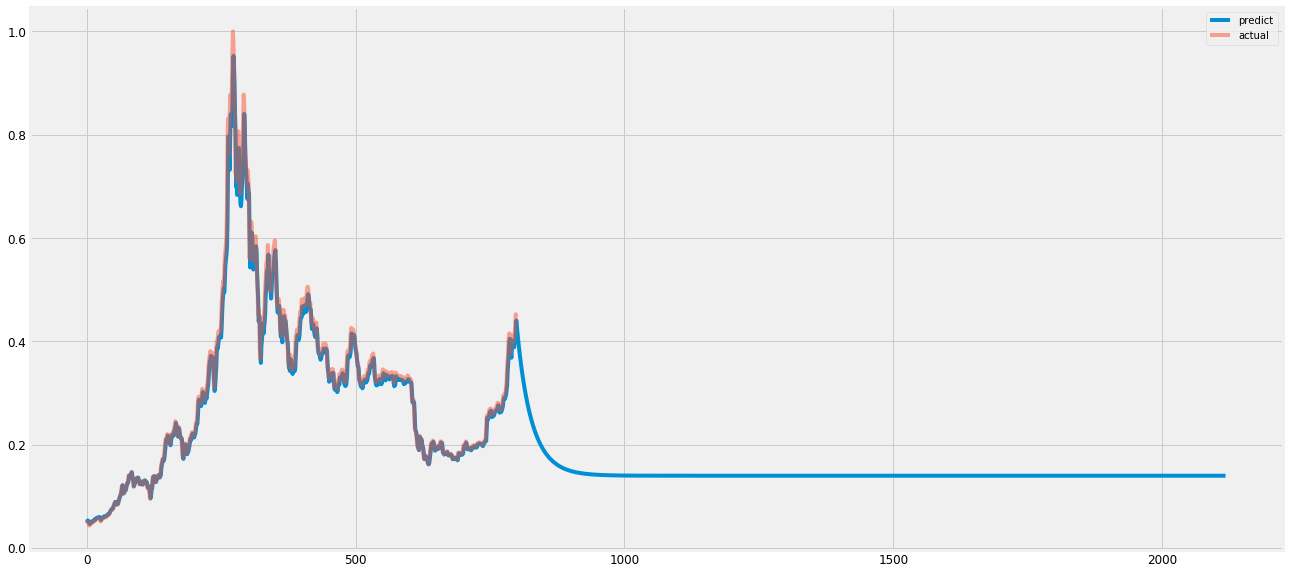

In [186]:
plt.plot(yklat, label='predict')
plt.plot(testY, label='actual', alpha=0.5)
plt.legend()
plt.show()

# Refferences
* https://www.geeksforgeeks.org/introduction-to-recurrent-neural-network/ (28/05/2019)
* https://colah.github.io/posts/2015-08-Understanding-LSTMs/ (28/05/2019)
* https://towardsdatascience.com/recurrent-neural-networks-and-lstm-4b601dd822a5 (28/05/2019)